In [30]:
import pandas as pd
import numpy as np

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
%matplotlib inline

In [14]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')

In [15]:
df.columns

Index(['Make', 'Model', 'Year', 'Engine Fuel Type', 'Engine HP',
       'Engine Cylinders', 'Transmission Type', 'Driven_Wheels',
       'Number of Doors', 'Market Category', 'Vehicle Size', 'Vehicle Style',
       'highway MPG', 'city mpg', 'Popularity', 'MSRP'],
      dtype='object')

### Data prepration

In [17]:
df = df[['Make',
'Model',
'Year',
'Engine HP',
'Engine Cylinders',
'Transmission Type',
'Vehicle Style',
'highway MPG',
'city mpg',
'MSRP']]
df.head()

,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [18]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.columns

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg',
       'msrp'],
      dtype='object')

In [19]:
df.isna().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

In [20]:
df.engine_hp.fillna(0,inplace=True)
df.engine_cylinders.fillna(0,inplace=True)
df.isna().sum()

C:\Users\hatem.kamal\AppData\Local\Temp\ipykernel_30204\2286897534.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.engine_hp.fillna(0,inplace=True)
C:\Users\hatem.kamal\AppData\Local\Temp\ipykernel_30204\2286897534.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.engine_cylinders.fillna(0,inplace=True)


make                 0
model                0
year                 0
engine_hp            0
engine_cylinders     0
transmission_type    0
vehicle_style        0
highway_mpg          0
city_mpg             0
msrp                 0
dtype: int64

In [21]:
df['above_average'] = (df.msrp>df.msrp.mean()).astype(int)
df['above_average']

C:\Users\hatem.kamal\AppData\Local\Temp\ipykernel_30204\3232783122.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['above_average'] = (df.msrp>df.msrp.mean()).astype(int)


0        1
1        1
2        0
3        0
4        0
        ..
11909    1
11910    1
11911    1
11912    1
11913    0
Name: above_average, Length: 11914, dtype: int32

### spliting the data

In [22]:
df_model = df.copy()
del df_model['msrp']

In [23]:
df_full_train, df_test = train_test_split(df_model, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

### AUC

In [28]:
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

In [35]:
# can't train the model with 1 feature so used a workaround for the problem
numeric = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
for n in numeric:
    nu = numeric.copy()
    nu.remove(n)
    
    model = LogisticRegression()
    model.fit(df_train[nu], y_train)


    y_pred = model.predict_proba(df_train[nu])[:, 1]
    churn_decision = (y_pred >= 0.5)
    print(f'without {n} : {roc_auc_score(churn_decision, y_train)}')

without engine_hp : 0.7451091546640772
without engine_cylinders : 0.8502792652050721
without highway_mpg : 0.8515335312936401
without city_mpg : 0.8500490118853822


In [36]:
train_dict = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

DictVectorizer(sparse=False)

In [38]:
X_train = dv.transform(train_dict)

In [60]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
above_avg = y_pred > 0.5


print(f'{roc_auc_score(above_avg, y_val)}')

0.919096905668472


In [65]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

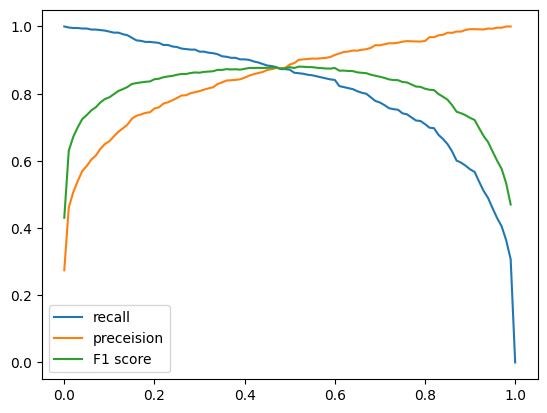

In [69]:
scores = []
for t in np.linspace(0,1,101):
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['rc'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['pr'] = df_scores.tp / (df_scores.fp + df_scores.tp)
    df_scores['F1'] = 2*(df_scores.pr*df_scores.rc)/(df_scores.pr+df_scores.rc)

plt.plot(df_scores.threshold, df_scores['rc'], label='recall')
plt.plot(df_scores.threshold, df_scores['pr'], label='preceision')
plt.plot(df_scores.threshold, df_scores['F1'], label='F1 score')
plt.legend()

In [71]:
df_scores[df_scores.F1 == df_scores.F1.max()]

,threshold,tp,fp,fn,tn,rc,pr,F1
52,0.52,563,62,91,1667,0.860856,0.9008,0.880375


### kfold

In [74]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

c:\Users\hatem.kamal\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [80]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear',C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [81]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [82]:
n_splits = 5

#for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    del df_train['above_average']
    del df_val['above_average']

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)



In [85]:
mean = sum(scores) / len(scores) 
variance = sum([((x - mean) ** 2) for x in scores]) / len(scores) 
res = variance ** 0.5
 
# Printing result 
print("Standard deviation of sample is : " + str(round(res, 3))) 

Standard deviation of sample is : 0.003


In [87]:
n_splits = 5

for C in tqdm([0.01, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        del df_train['above_average']
        del df_val['above_average']

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

 25%|██▌       | 1/4 [00:01<00:03,  1.11s/it]

C=0.01 0.952 +- 0.002


 50%|█████     | 2/4 [00:01<00:01,  1.14it/s]

C=0.1 0.972 +- 0.002


 75%|███████▌  | 3/4 [00:02<00:00,  1.10it/s]

C=0.5 0.978 +- 0.001


100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

C=10 0.983 +- 0.003
